In [8]:
from math import *
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

years = [1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000]
population = [92228496, 106021537, 123202624, 132164569, 151325798, 179323175, 203211926, 226545805, 248709873, 281421906]

future_year = 2010
future_population = 308745538

def get_formatter(order):
    return FuncFormatter(lambda x, pos: f"{(x / 10**order):.0f}")

def extrapolate(name, model, years, population, future_year, future_population):
    xs = [x for x in range(min(years) - 5, future_year + 6)]
    ys = [model(year) for year in xs]
    plt.title(name)
    plt.xlabel("year")
    plt.ylabel("population, $10^6$")
    ax = plt.gca()
    ax.ticklabel_format(style='plain', axis='both')
    ax.yaxis.set_major_formatter(get_formatter(6))
    plt.plot(xs, ys, color="#8B0000")
    plt.stem(years, population, markerfmt='.')
    plt.stem([future_year], [future_population], markerfmt='gD', basefmt="--")
    deviation = abs(model(future_year) - future_population)
    plt.figtext(0.5, -0.05, f"deviation: {deviation:.0f}({(deviation / future_population * 100):.2f}%)", ha='center', fontsize=12)
    plt.show()

### Least Squares Method with exponential function $f(x) = e^{G(x - x_0)}$

G = 0.012433169222448134
x0 = 433.7236852928804


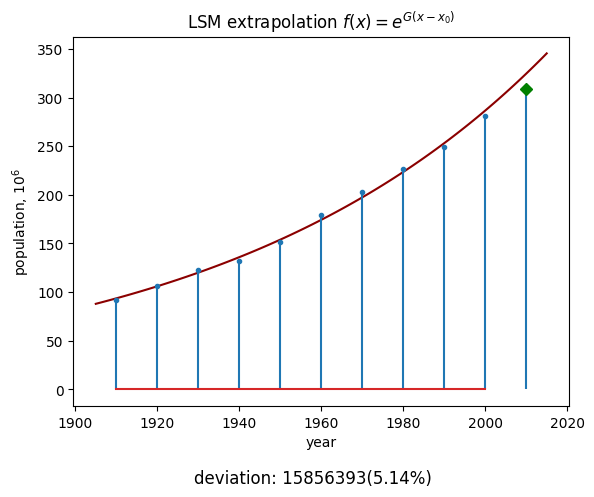

In [9]:
def check_args(xs, ys):
    if len(xs) != len(ys):
        raise Exception(f"len(xs) = {len(xs)} != {len(ys)} = len(ys)")

# f(x) = kx + b
class LinearFunciton:
    def __init__(self, k : float, b : float):
        self.k = k
        self.b = b

    def __call__(self, x : float) -> float:
        return self.k * x + self.b

# f(x) = e^{G(x - x0)}
class ExponentialFunction:
    def __init__(self, G : float, x0 : float):
        self.G = G
        self.x0 = x0

    def __call__(self, x : float) -> float:
        return exp(self.G * (x - self.x0))
    
def get_linear_LSM_function(xs : list[float], ys : list[float]) -> LinearFunciton:
    check_args(xs, ys)
    sum_x = sum(xs)
    sum_y = sum(ys)
    sum_xy = sum(map(lambda x, y: x*y, xs, ys))
    sum_xx = sum(map(lambda x: x*x, xs))
    N = len(xs)
    k = (N * sum_xy - sum_x * sum_y) / (N * sum_xx - sum_x * sum_x)
    b = (sum_y - k * sum_x) / N
    return LinearFunciton(k, b)

def get_exponential_LSM_function(xs : list[float], ys : list[float]) -> ExponentialFunction:
    index = get_linear_LSM_function(xs, list(map(log, ys)))
    return ExponentialFunction(index.k, -index.b / index.k)

model = get_exponential_LSM_function(years, population)
print("G =", model.G)
print("x0 =", model.x0)
extrapolate("LSM extrapolation $f(x) = e^{G(x-x_0)}$", model, years, population, future_year, future_population)

### Newton's interpolation polynomial

Only every third point was taken from the data to reduce instability and avoid fluctuations.

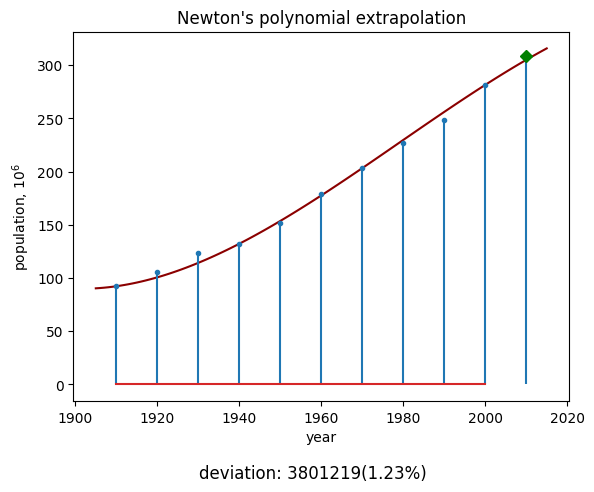

In [10]:
def get_divided_differences(xs, ys):
    n = len(xs)
    table = [[0] * n for _ in range(n)]
    for i in range(n):
        table[i][0] = ys[i]
    for j in range(1, n):
        for i in range(n - j):
            table[i][j] = (table[i+1][j-1] - table[i][j-1]) / (xs[i+j] - xs[i])
    return table

def calculate_Newtons_Polynomial(xs, coefs, x):
    result = 0
    for n in range(1, len(coefs)):
        result = (result + coefs[-n]) * (x - xs[-n - 1])
    return coefs[0] + result

def get_Newtons_Polynomial(xs, ys):
    check_args(xs, ys)
    div_diffs = get_divided_differences(xs, ys)
    return lambda x: calculate_Newtons_Polynomial(xs, div_diffs[0], x)

model = get_Newtons_Polynomial(years[::3], population[::3])
extrapolate("Newton's polynomial extrapolation", model, years, population, future_year, future_population)

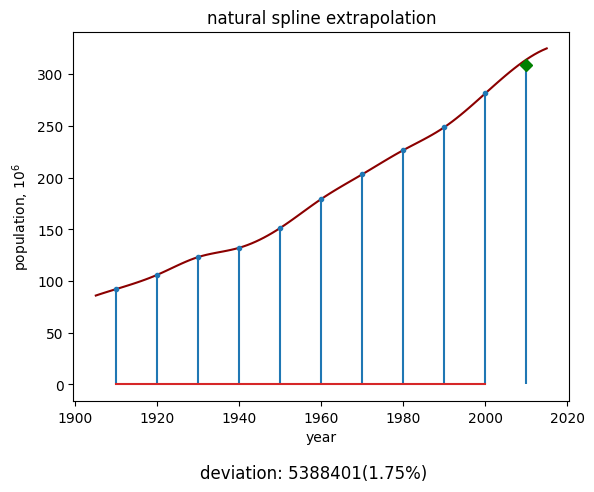

In [31]:
def calculate_spline(x, next_x, prev_x, next_m, prev_m, alpha, beta, h):
    next_dx = next_x - x
    prev_dx = x - prev_x
    return (prev_m * next_dx**3 + next_m * prev_dx**3 + alpha * next_dx + beta * prev_dx) / h

class NaturalSpline():
    def __init__(self, xs : list[float], ys : list[float], left_second_derivative : float = 0, right_second_derivative : float = 0):
        check_args(xs, ys)
        self.n = len(xs) - 1
        self.xs = xs
        self.h = [xs[i + 1] - xs[i] for i in range(self.n)]
        p = [0]
        r = [left_second_derivative / 6] # m[i] already divided by 6
        for i in range(1, self.n):
            Fi = (ys[i + 1] - ys[i]) / self.h[i] - (ys[i] - ys[i - 1]) / self.h[i-1]
            ai = self.h[i-1]
            bi = 2 * (self.h[i] + self.h[i-1])
            ci = self.h[i]
            denominator = bi - ai * p[-1]
            p += [ci / denominator]
            r += [(Fi - ai*r[-1]) / denominator]
        self.m = [0 for _ in range(self.n + 1)]
        self.m[self.n] = right_second_derivative / 6
        for i in range(self.n - 1, -1, -1):
            self.m[i] = r[i] - p[i] * self.m[i+1]
        self.alpha = [ys[i] - self.m[i]*self.h[i]*self.h[i] for i in range(self.n)]
        self.beta = [ys[i + 1] - self.m[i + 1]*self.h[i]*self.h[i] for i in range(self.n)]

    def __call__(self, x : float) -> float:
        for i in range(self.n):
            if self.xs[i] <= x <= self.xs[i+1]:
                return calculate_spline(x, self.xs[i+1], self.xs[i], self.m[i+1], self.m[i], self.alpha[i], self.beta[i], self.h[i])
        if x < self.xs[0]:
            return calculate_spline(x, self.xs[1], self.xs[0], self.m[1], self.m[0], self.alpha[0], self.beta[0], self.h[0])
        if x > self.xs[-1]:
            return calculate_spline(x, self.xs[-1], self.xs[-2], self.m[-1], self.m[-2], self.alpha[-1], self.beta[-1], self.h[-1])
        raise Exception("bad spline")

model = NaturalSpline(years, population)
extrapolate("natural spline extrapolation", model, years, population, future_year, future_population)